# 02 — Feature Engineering

This notebook transforms the raw features into improved predictors for ML models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sns.set()

df = pd.read_csv("../data/processed/data_for_model.csv")
df.head()


,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,weekend,is_holiday
0,60,2022-01-01,2682731,1247708,134.0,2022,1,0.0,2.6,5,True,True
1,732,2022-01-01,2681319,1248665,447.0,2022,1,0.0,2.6,5,True,True
2,1037,2022-01-01,2681339,1248647,1141.0,2022,1,0.0,2.6,5,True,True
3,2977,2022-01-01,2682681,1250570,259.0,2022,1,0.0,2.6,5,True,True
4,2978,2022-01-01,2683406,1251617,97.0,2022,1,0.0,2.6,5,True,True


# Temporal Features

In [2]:
##Extract richer date/time features (seasonality, periodicity)
# Make sure Datum is a proper datetime column
df["Datum"] = pd.to_datetime(df["Datum"])
# Day features
df["month"] = df["Datum"].dt.month
df["week"] = df["Datum"].dt.isocalendar().week.astype(int)
df["quarter"] = df["Datum"].dt.quarter

# Cyclic encoding for day_of_year (recommended!)
df["year_length"] = df["Datum"].dt.is_leap_year.map({True: 366, False: 365})
df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / 365)


# Weather Features

In [3]:
# feels-like temp: better predictor than raw temp
df["temp_feels"] = df["Temperatur Durchschnitt"] - 0.7 * df["Niederschlag"]

# squared temperature (captures "too hot / too cold")
df["temp_sq"] = df["Temperatur Durchschnitt"] ** 2

# is it raining at all?
df["is_rain"] = (df["Niederschlag"] > 0).astype(int)

# hard rain indicator
df["heavy_rain"] = (df["Niederschlag"] > 5).astype(int)


# Rolling Features

In [4]:
#Rolling means by station
df = df.sort_values(by=["Standort_ID", "Datum"])

df["velo_roll3"] = df.groupby("Standort_ID")["Velo"].rolling(3).mean().reset_index(level=0, drop=True)
df["velo_roll7"] = df.groupby("Standort_ID")["Velo"].rolling(7).mean().reset_index(level=0, drop=True)

# Lag yesterday's velo count
df["velo_lag1"] = df.groupby("Standort_ID")["Velo"].shift(1)
df["velo_lag7"] = df.groupby("Standort_ID")["Velo"].shift(7)

# handle missing values
df["velo_lag1"] = df["velo_lag1"].fillna(df["Velo"].median())
df["velo_lag7"] = df["velo_lag7"].fillna(df["Velo"].median())

df["velo_roll3"] = df["velo_roll3"].fillna(df["Velo"].median())
df["velo_roll7"] = df["velo_roll7"].fillna(df["Velo"].median())


# Clustering Stations

In [5]:
# Station-level average traffic
df_station_avg = df.groupby("Standort_ID")["Velo"].mean()

df["station_avg_traffic"] = df["Standort_ID"].map(df_station_avg)


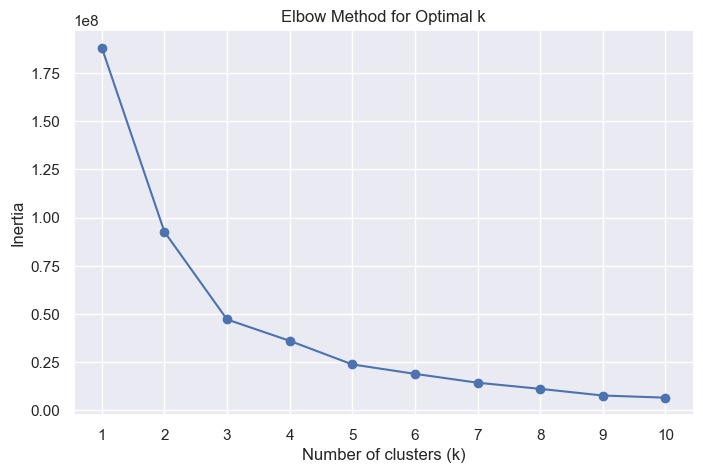

In [6]:
# Compute inertia (within-cluster distance) for k = 1–10
inertias = []
K_range = range(1, 11)

station_coords = df.groupby("Standort_ID")[["Koord_Ost", "Koord_Nord"]].mean()

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(station_coords)
    inertias.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(K_range)
plt.grid(True)
plt.show()


after 3 the drop is smaller, continue working with 3 clusters

In [7]:
# Build a station-level coordinates table
station_coords = df.groupby("Standort_ID")[["Koord_Ost", "Koord_Nord"]].mean()

# Choose number of clusters (you can change 6 to 4, 8, etc.)
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans.fit(station_coords)

# Map each station to its spatial cluster
station_cluster = dict(zip(station_coords.index, kmeans.labels_))

df["location_cluster"] = df["Standort_ID"].map(station_cluster)

df[["Standort_ID", "Koord_Ost", "Koord_Nord", "location_cluster"]].head()

# Merge cluster labels back to the station_coords table
station_coords_plot = station_coords.copy()
station_coords_plot["location_cluster"] = kmeans.labels_

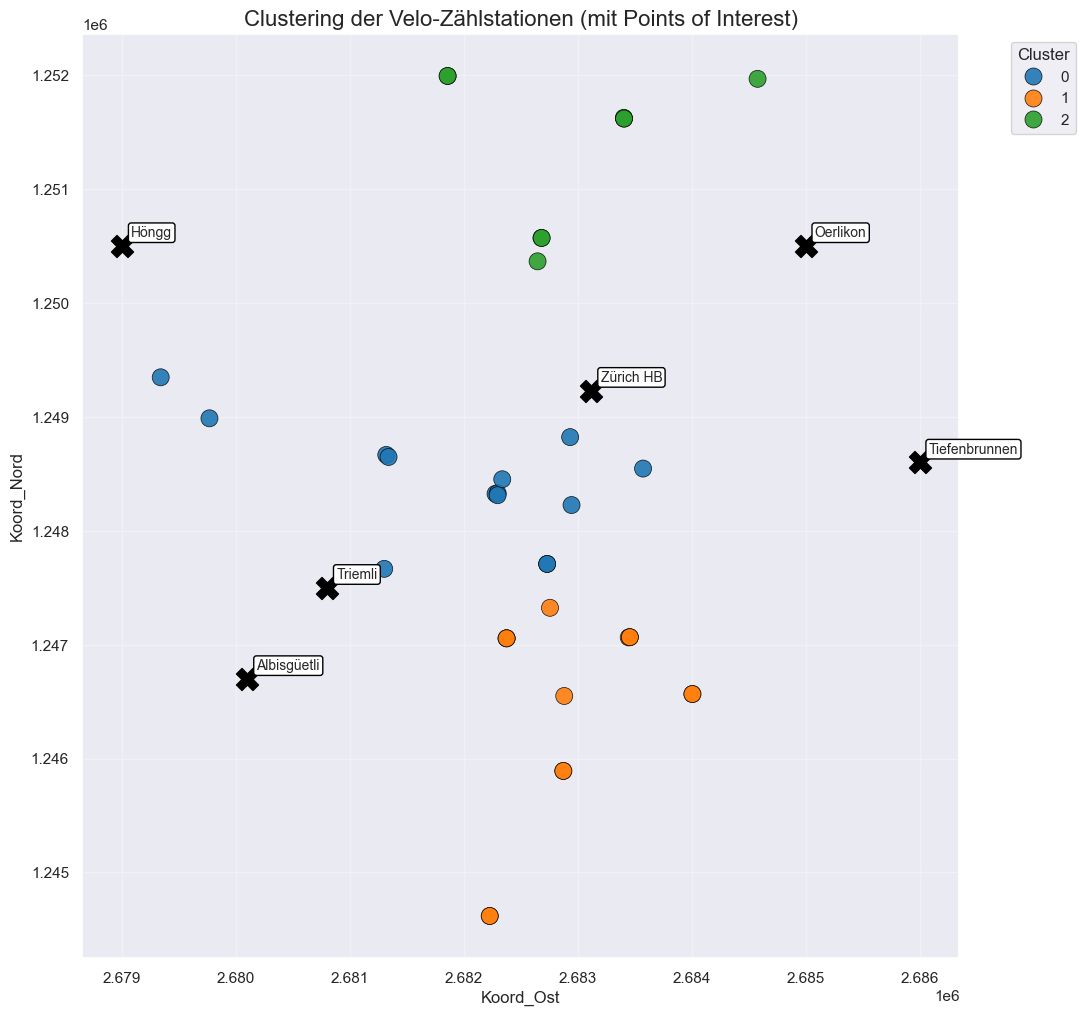

In [12]:
# Clean & Professional Zurich Cluster Visualization

# Build station-level summary table
station_stats = df.groupby("Standort_ID").agg(
    Koord_Ost=("Koord_Ost", "mean"),
    Koord_Nord=("Koord_Nord", "mean"),
    location_cluster=("location_cluster", "first")
)

plt.figure(figsize=(12, 12))

# Scatterplot for clusters
sns.scatterplot(
    data=station_stats,
    x="Koord_Ost",
    y="Koord_Nord",
    hue="location_cluster",
    palette="tab10",
    s=150,        # Fixed point size
    edgecolor="black",
    linewidth=0.5,
    alpha=0.9
)

# --- POIs ---
POIs = {
    "Zürich HB": (2683120, 1249230),
    "Oerlikon": (2685000, 1250500),
    "Albisgüetli": (2680100, 1246700), 
    "Tiefenbrunnen": (2686000, 1248600),
    "Höngg": (2679000, 1250500),
    "Triemli": (2680800, 1247500)
}

for name, (x, y) in POIs.items():
    plt.scatter(x, y, s=250, marker="X", color="black")
    plt.text(
        x + 80, y + 80, name,
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2")
    )

# --- Styling ---
plt.title("Clustering der Velo-Zählstationen (mit Points of Interest)", fontsize=16)
plt.xlabel("Koord_Ost", fontsize=12)
plt.ylabel("Koord_Nord", fontsize=12)

plt.gca().set_aspect("equal", adjustable="box")

# Legende optimieren
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=True
)

plt.grid(alpha=0.3)
plt.show()


# Save CSV

In [13]:
df.to_csv("../data/processed/data_for_model_engineered.csv", index=False)
df.head()


,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,...,temp_feels,temp_sq,is_rain,heavy_rain,velo_roll3,velo_roll7,velo_lag1,velo_lag7,station_avg_traffic,location_cluster
0,60,2022-01-01,2682731,1247708,134.0,2022,1,0.0,2.6,5,...,2.60,6.76,0,0,1130.000000,1130.0,1130.0,1130.0,823.141573,0
21,60,2022-01-02,2682731,1247708,189.0,2022,2,0.0,4.9,6,...,4.90,24.01,0,0,1130.000000,1130.0,134.0,1130.0,823.141573,0
42,60,2022-01-03,2682731,1247708,676.0,2022,3,0.0,10.2,0,...,10.20,104.04,0,0,333.000000,1130.0,189.0,1130.0,823.141573,0
63,60,2022-01-04,2682731,1247708,646.0,2022,4,6.4,11.0,1,...,6.52,121.00,1,1,503.666667,1130.0,676.0,1130.0,823.141573,0
84,60,2022-01-05,2682731,1247708,518.0,2022,5,10.9,1.7,2,...,-5.93,2.89,1,1,613.333333,1130.0,646.0,1130.0,823.141573,0
